#**Principal Component Analysis**

* Used for dimensionality reduction
* Reduces the number of features, so that model can be trained quickly and accurately
* Helps find highly correlated features
* Can be used in model overfitting situations
* PCA is not an algorithm, rather a unsupervised ML technique that can be used along with different algorithms for reducing the number of features

In [ ]:
#importing libraries
import os
import sys 
import cv2 as cv
import numpy as np
import plotly.io as pio
import ipywidgets as widget
import plotly.graph_objs as go
import matplotlib.pyplot as plt


from PIL import Image
from skimage import color
from plotly import subplots
from random import randrange
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from ipywidgets import interact, interactive, fixed, interact_manual



# #setting the rederer as colab
# pio.renderers.default = "colab"

## Step 1. **Load dataset**

In [ ]:
# path to images
IMG_DIR = 'brain_tumor_dataset'


X_no = []
X_flat_no = []

size = 100

# iterate through images
for img in os.listdir(IMG_DIR):

    # read and grayscale image
    img_array = cv.imread(os.path.join(IMG_DIR, img), cv.IMREAD_GRAYSCALE)
    
    # form matrix of an image
    img_pil = Image.fromarray(img_array)

    # resize image
    img_64x64 = np.array(img_pil.resize((size, size)))

    X_no.append(img_64x64)

    # flatten the image
    img_array = img_64x64.flatten()

    X_flat_no.append(img_array)

# convert to numpy array
X_flat_no = np.asarray(X_flat_no)

# images as columns
X_flat_no = X_flat_no.T

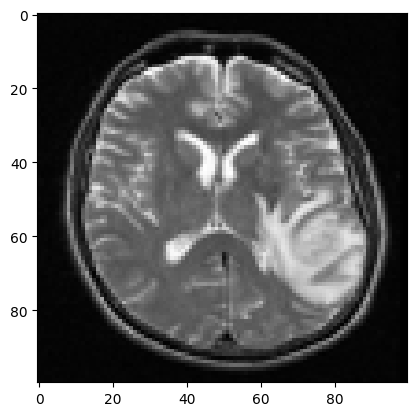

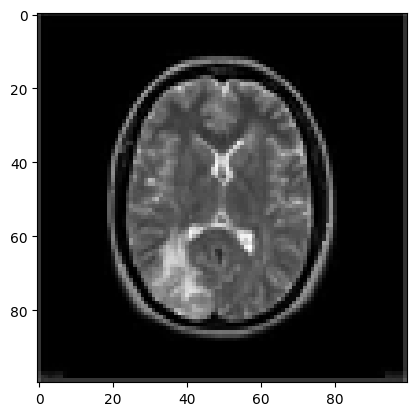

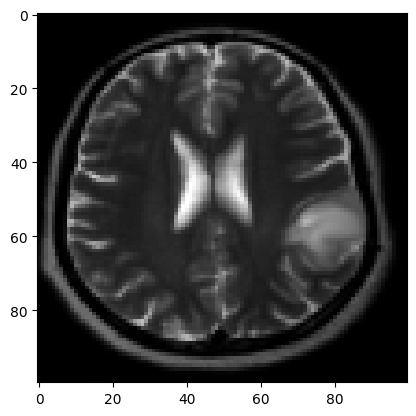

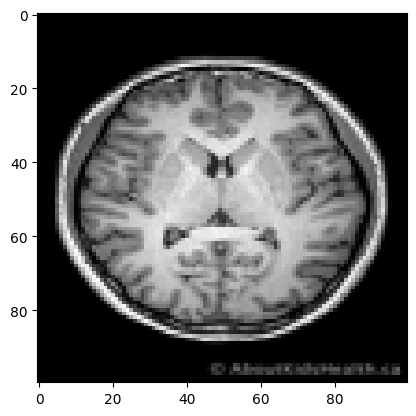

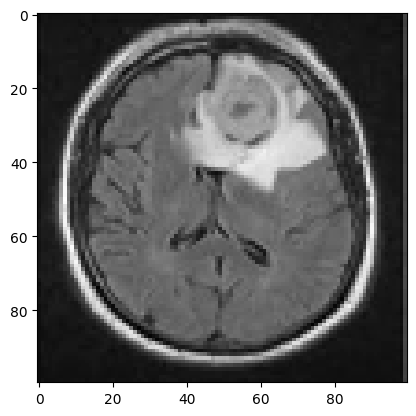

In [ ]:
# ask about size!!!

def list_show_annotation(dataset, num_images_disp):
  
  for _ in range(num_images_disp):

    img_no = randrange(len(dataset))	

    plt.imshow(dataset[img_no], cmap='gray')
    plt.show()

  return
  
list_show_annotation(X_no, 5)

## Step 2. **Normalize data**

Prior to performing PCA, it is common practice to standardize/normalize the data. It is done so that all features are at the same scale and none of them is dominating. During the process of standardization, the objective is to adjust the feature values to have a mean of 0 and a standard deviation of 1.

Mathematically, this transformation is achieved by subtracting the mean from each value of each variable, and then dividing by the standard deviation. This process ensures that the variables are standardized, allowing for a fair and unbiased comparison among them.

In [ ]:
def standardize(X):
    """
    The standardize function standardizes the input matrix X 
    by subtracting the mean of each column and dividing by the standard deviation.
    
    Returns the standardized matrix X_stand, mean (mu) 
    and standard deviation (std) values used in the standardization process.
    """

    # calcualte the mean of each respective column   
    mu = np.mean(X, axis = 0)

    # calcualte the standard deviation of each column
    std = np.std(X, axis = 0)  
    
    # substract the mean from X
    X = X - mu   
    
    # handle zero std case (cannot divide by zero)
    std_filled = std.copy()
    std_filled[std == 0] = 1
    
    #calculate standardized X
    X_stand = (X - mu) / std_filled
    
    return X_stand, mu, std

In [ ]:
#standardizind
X_stand_train, mu_train, std_train = standardize(X_flat_no)

##Step 3. **Compute eigenvectors of covariance matrix**

Next, we proceed with the eigendecomposition of the covariance matrix, which yields eigenvalues and eigenvectors. The number of eigenvalues and eigenvectors obtained, will be equivalent to the number of features (images) in the dataset.

The eigenvector that corresponds to the largest eigenvalue identifies the direction of maximum variance, which is referred to as the *first principal component*. Similarly, the eigenvector associated with the second largest eigenvalue indicates the direction of the second largest variance, representing the *second principal component*. This pattern continues for subsequent eigenvectors and eigenvalues.

! All eigenvectors are pairwise orthogonal (since the covariance matrix is symmetric).


In [ ]:
def eigen(X):
    """
    The eigen function finds the eigenvalues and eigenvectors of input matrix X 
    using build-in function of numpy.
    
    Returns eigenvalues (EV) and eigenvectors (EVc) of input matrix X, sorted in
    descending order.
    """
  
    #calculate the eigen values and eigen vectors
    EV, EVc = np.linalg.eigh(X)  

    # order of eigenvalues (bigger to smaller)
    order = np.argsort(-EV)

    # order the EV's
    EV = EV[order]

    # construct matrix of eigenvectors
    EVc = EVc[:, order]
    
    return EV, EVc

##Step 4. **Compute the covariance matrix** & Step 5: **Select N components (feature vectors)**


To understand the relationships between features and identify if there is high correlation or redundant information, we create a covariance matrix. This matrix helps us see how the features are related to each other. If certain features are highly correlated, it suggests that they provide similar information. By examining the covariance matrix, we can determine which features to remove in order to eliminate redundancy.

These are the selected principal components, the vectors that we consider to be adequate in representing the data without significant information loss. These components are chosen based on their ability to capture the most significant patterns and variability in the data.


In [ ]:

def PCA(X, num_components):
    """
    The PCA function finds the projection matrix based on the input matrix X 
    and the number of components we want to use.
    This projection matrix will help us to reorient the data from
    the original axes to the ones described by the principal components.
    This will give us the data with reduced dimensions.
    
    Returns projection matrix to less dimentional axes.
    """

    # calculate the data covariance matrix S
    S = 1 / (len(X) - 1) * np.matmul(X, X.T)
    
    # eigenvalues and corresponding eigenvectors for S
    eig_vals, eig_vecs = eigen(S)
    
    # select eigenvectors
    U = eig_vecs[:, range(num_components)]
    
    # find the projection matrix which projects our input data onto
    # the vector space spanned by the eigenvectors
    P = np.matmul(U, U.T)
    
    return P

In [ ]:
#calculating loss and reconstructing images

loss = []
reconstructions = []

max_components = len(np.array(X_flat_no).T)

for num_component in range(1, max_components + 1):

    # find projection matrix for such number of components
    projection = PCA(X_stand_train.T, num_component)

    # find the transfomation of original matrix
    # on lower dimensional space
    y_transform = np.matmul(X_flat_no, projection)

    # find the error between original data and transformed one
    error = mse(y_transform, X_flat_no)

    # append the transformation to the container
    reconstructions.append(y_transform)

    # append the information about number of components used and
    # the error recored (from visualization)
    loss.append((num_component, error))


## Step 6: **Visualization**

In [ ]:
#unstandardizing the reconstructed images
reconstructions = np.asarray(reconstructions)
loss = np.asarray(loss)

In [ ]:
img_no = randrange(len(X_no))
image = X_no[img_no]

In [ ]:
@interact(num_components=widget.IntSlider(min=1, max=max_components-1, value=10), image=fixed(image))
def display_pca_image(num_components, image):

    plt.imshow(reconstructions[num_components, : , 0].reshape(100, 100), cmap='gray')
    plt.show()
    

interactive(children=(IntSlider(value=10, description='num_components', max=252, min=1), Output()), _dom_class…

In [ ]:
#visualizing mse vs number of principal components
trace = go.Scatter(x = loss[:, 0], y = loss[:, 1])
fig = go.Figure([trace])
fig.update_layout(title = "MSE vs number of principal components", xaxis_title = "Number of principal components",  yaxis_title = "MSE")
fig.show()